In [ ]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conns = pd.read_csv('Connections.csv')
segs = pd.read_csv('L5Segments.csv')
#conns[conns['Source Population']=='exc_stim']['Conductance'].hist(bins=40)

#conns[conns['Source Population']=='exc_stim']['Conductance'].max()

In [336]:
segs['segmentID'] = segs.index

In [337]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))


In [338]:
conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

In [339]:
conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)

In [340]:
df = segs.set_index(['Type','Sec ID','X']).join(conns.set_index(['Type','Sec ID','X'])).reset_index()

In [341]:
df_syn_count = df.groupby(['segmentID','Source Population'])['X'].count().reset_index()

In [342]:
df_syn_count[df_syn_count['Source Population']=='exc_stim']

,segmentID,Source Population,X
8,54,exc_stim,15
10,116,exc_stim,7
13,139,exc_stim,23
15,142,exc_stim,19
17,145,exc_stim,4
...,...,...,...
343,2493,exc_stim,29
345,2495,exc_stim,7
347,2496,exc_stim,24
349,2501,exc_stim,24


In [343]:
f = h5py.File('./output_control/v_report.h5','r')
#g = h5py.File('./output_NMDAblock/v_report.h5','r')
#x = h5py.File('./output_nablock/v_report.h5','r')

h = h5py.File('./output_control/inmda_report.h5','r')
#i = h5py.File('./output_NMDAblock/inmda_report.h5','r')

#cont_na = h5py.File('./output_control/NaTa_t.gNaTa_t_report.h5','r')
#spks = h5py.File('./output_control/spikes.h5','r')

In [344]:
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [345]:
#control_v = f['report']['biophysical']['data'][:]
#NMDAblock_v = g['report']['biophysical']['data'][:]
#nablock_v = x['report']['biophysical']['data'][:]

#control_inmda = h['report']['biophysical']['data'][:]
#NMDAblock_inmda = i['report']['biophysical']['data'][:]

#control_gna = cont_na['report']['biophysical']['data'][:]

spktimes = spks['spikes']['biophysical']['timestamps'][:]

In [346]:
na_df = pd.DataFrame(columns=['seg_id','na_lower_bound'])

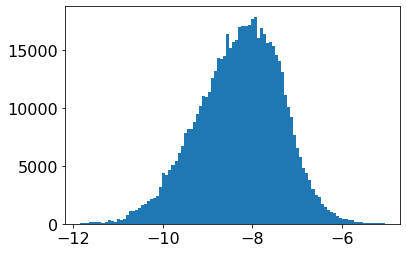

In [348]:
plt.hist(np.log(np.abs(h['report']['biophysical']['data'][h['report']['biophysical']['data'][:,54]!=0,54])),bins=100)
plt.show()

In [ ]:
sns.jointplot(x=f['report']['biophysical']['data'][:,54], y=h['report']['biophysical']['data'][:,54],alpha=0.02)
plt.ylim(-0.007,0.0001)

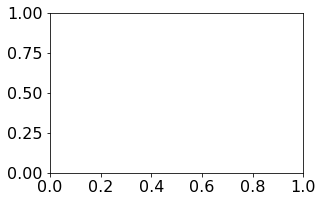

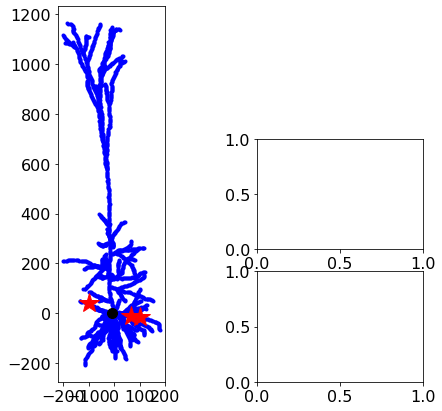

In [354]:
plt.figure(figsize=(10,10))


plt.subplot(3,2,2)
sns.jointplot(x=f['report']['biophysical']['data'][:,54], y=h['report']['biophysical']['data'][:,54])

plt.subplot(3,2,4)
#plt.hist(np.log(np.abs(h['report']['biophysical']['data'][h['report']['biophysical']['data'][:,77]!=0,77])),bins=100)

plt.subplot(3,2,6)
#plt.hist(np.log(np.abs(h['report']['biophysical']['data'][h['report']['biophysical']['data'][:,552]!=0,552])),bins=100)

plt.subplot(1,3,1)
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[54,'Coord X'], segs.loc[54,'Coord Y'], 'r*',markersize=20)
plt.plot(segs.loc[77,'Coord X'], segs.loc[77,'Coord Y'], 'r*',markersize=20)
plt.plot(segs.loc[549,'Coord X'], segs.loc[549,'Coord Y'], 'r*',markersize=20)
plt.xticks(ticks=[-200,-100,0,100,200])

plt.show()


(300000, 400000)

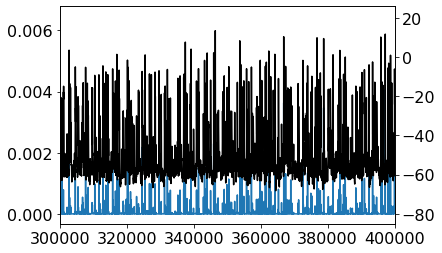

In [153]:
plt.plot(cont_na['report']['biophysical']['data'][:,100])
#plt.ylim(0,0.0001)
plt.twinx()
plt.plot(f['report']['biophysical']['data'][:,100],color='k')
plt.xlim(300000,400000)

In [12]:
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    threshold_crossings = np.diff(cont_na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    if len(upward_crossings)>0:
        na_df = na_df.append(pd.DataFrame({'seg_id':np.tile(p,upward_crossings.shape[0]),
                                               'na_lower_bound':upward_crossings}))
    else:
        na_df = na_df.append(pd.DataFrame({'seg_id':p,
                                               'na_lower_bound':np.array([np.nan])}))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


In [129]:
nmda_df = pd.DataFrame(columns=['seg_id','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    legit_uc = voltage_criterion(data=f['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=f['report']['biophysical']['data'][:,p],v_thresh=-40, time_thresh=260)[-1]
    
    # check if voltage_criterion values are within 26 ms any somatic spikes
    legit_uc_iso = [np.int(i*10) for i in legit_uc/10 if ~np.any(np.abs(i-spktimes) < 26)]
    
    # replace downward crossing with soma spike time if the up/down crossing spans a spike
    legit_dc_iso = [np.min([np.sort(legit_dc[legit_dc>i])[0],
                            int(np.sort(spktimes[spktimes>i/10])[0]*10)]) for i in legit_uc_iso]
    
    if (len(legit_uc_iso)!=0) & (np.min(h['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=h['report']['biophysical']['data'])
        nmda_df = nmda_df.append(pd.DataFrame({'seg_id':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'seg_id':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


In [148]:
np.log(nmda_df[(nmda_df.seg_id<=1026)&(~pd.isnull(nmda_df.mag))]['mag'])

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
247   NaN
248   NaN
249   NaN
250   NaN
251   NaN
Name: mag, Length: 20032, dtype: float64

(-20, 1)

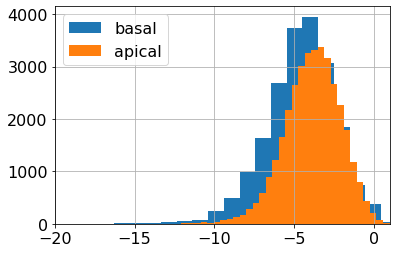

In [152]:
np.log(np.abs(nmda_df[(nmda_df.seg_id<=1026)&(~pd.isnull(nmda_df.mag))]['mag'])).hist(bins=100,label='basal')
np.log(np.abs(nmda_df[(nmda_df.seg_id>1026)&(~pd.isnull(nmda_df.mag))]['mag'])).hist(bins=100,label='apical')
plt.legend()
plt.xlim(-20,1)

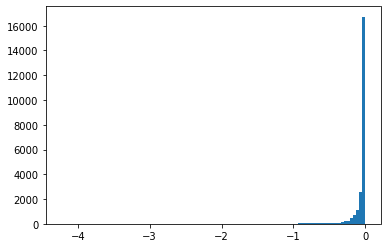

In [52]:
plt.hist(nmda_df[~pd.isnull(nmda_df.mag)]['mag'],bins=100)
plt.show()

In [77]:
nmda_df[nmda_df.mag<-0.001]['seg_id']

0      175
1      175
2      175
3      175
4      175
      ... 
91    1139
92    1139
93    1139
94    1139
95    1139
Name: seg_id, Length: 20044, dtype: object

In [111]:
segs = pd.read_csv('L5Segments.csv')
segs.loc[175,:]

BMTK ID           14
X           0.465517
Type            dend
Sec ID            13
Distance      143.35
Coord X      102.197
Coord Y     -41.1778
Coord Z     -51.5787
Name: 175, dtype: object

In [118]:
segs[segs.Type=='apic'].index.min()

1027

In [123]:
nmda_df[(nmda_df.seg_id>=1000)]

,seg_id,nmda_lower_bound,nmda_upper_bound,mag
0,1000,NaN,NaN,NaN
0,1001,NaN,NaN,NaN
0,1002,NaN,NaN,NaN
0,1003,NaN,NaN,NaN
0,1004,NaN,NaN,NaN
...,...,...,...,...
91,1139,536773,537659,-0.045806
92,1139,553412,554060,-0.052846
93,1139,561524,562130,-0.054414
94,1139,569684,569934,-0.010696


Text(0, 0.5, 'current (nA)')

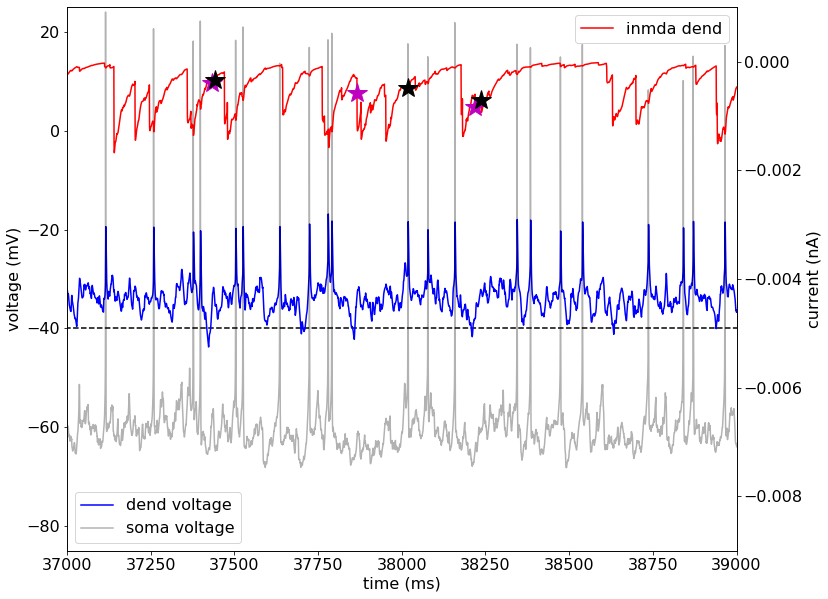

In [128]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

ind = 1139
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
plt.ylim(-0.009,0.001)
plt.xlim(37000,39000)
plt.ylabel('current (nA)')


Text(0, 0.5, 'current (nA)')

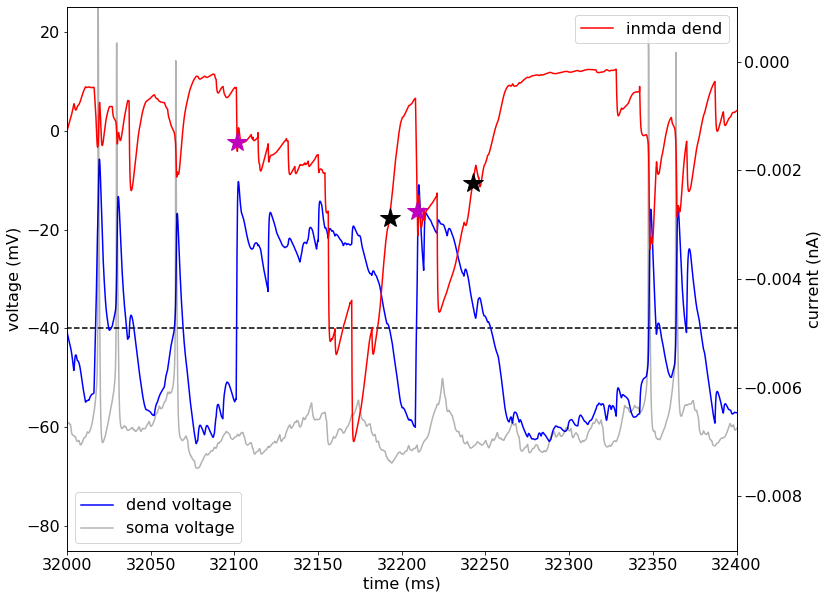

In [99]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
plt.xlim(32000,32400)
plt.ylim(-0.009,0.001)
plt.ylabel('current (nA)')


In [46]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [44]:
np.arange(-30,31,5).shape

(13,)

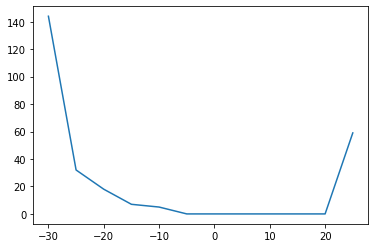

In [47]:
plt.plot(np.arange(-30,30,5),n)

In [26]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

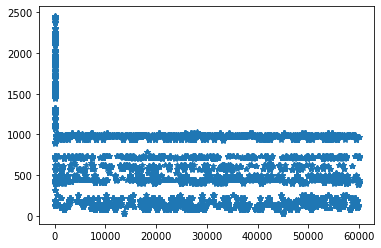

In [29]:
plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
         na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

NameError: name 'nmda_df' is not defined

NameError: name 'n' is not defined

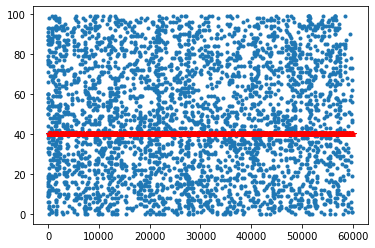

In [11]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [396]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

(6000, 7000)

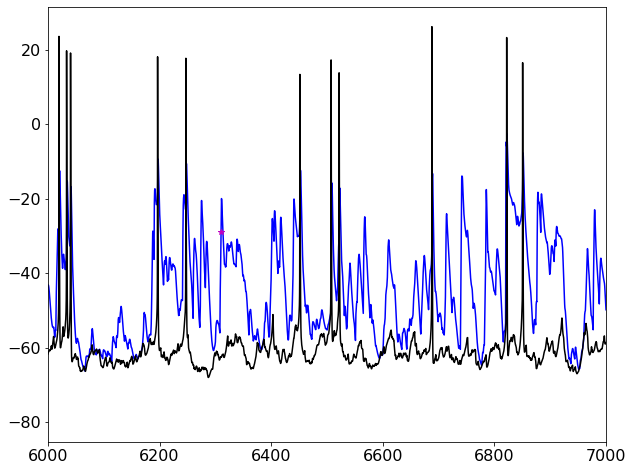

In [350]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
plt.xlim(6000,7000)

In [247]:
# ind1 = 3 sent to Drew
ind1 = 2
e1 = control_inmda[legit_uc_iso[ind1], p]
e2 = control_inmda[legit_dc_iso[ind1], p]
x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

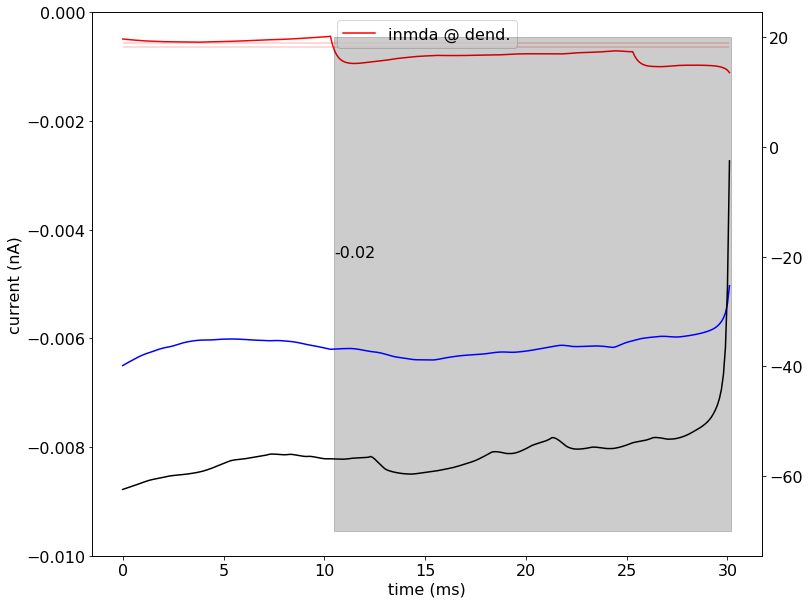

In [248]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.ylabel('current (nA)')
plt.ylim(-0.010,0)
plt.legend(loc='upper center')
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


for i in np.arange(0,len(bounds)):
    plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
    plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

Text(0.5, 1.0, '[  842  1647  2619  3554  4403  4838  5367  6259  6906  7343  9697 12390\n 12773 13771 14890 15884 17077 18595 19939 22066 23737 24284 25413 26597\n 27044 28429 30164 30801 31385 32087 32916 33723 35481 36024 37321 38402\n 39508 39990 41964 42943 43622 44147 45706 46043 46602 47522 48410 48800\n 49997 50965 51281 52498 53049 53683 54313 56634 57005 57875 59693 62229\n 63190 64370 64795 66494 68097 68880 69584 70642 71213 72545 73268 74657\n 75841 77213 79503 80633 81032 82026 82994 84010 85540 86223 87097 88434\n 91288 93667 94914 95493 96901 98894 99324]')

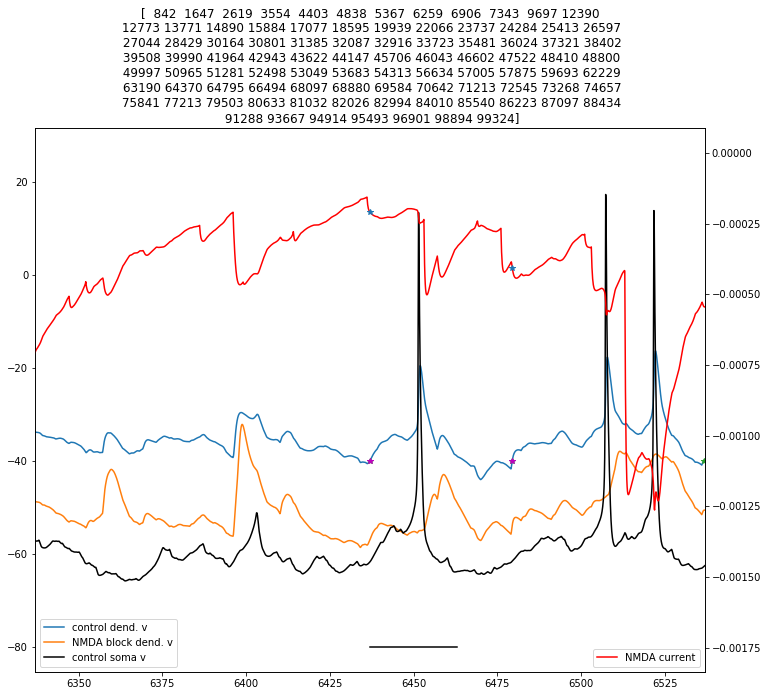

In [45]:
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

uc = voltage_criterion(control_v[:,p],-40)[0]


plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

plt.plot([center,center+26],[-80,-80],color='k')
plt.legend(loc='lower left')

plt.twinx()
plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
#plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
plt.xlim(center-100,center+100)

plt.legend(loc='lower right')
plt.title('{}'.format(legit_uc))

(-65, 0)

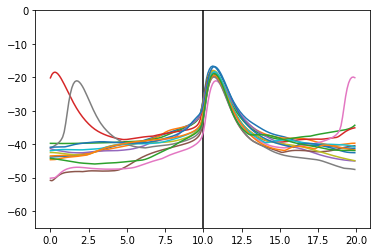

In [332]:
p = np.random.choice(segs[segs.Type=='apic'].index)
for i in spktimes:
    plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
plt.vlines(10,-65,0,color='k')
plt.ylim(-65,0)

No handles with labels found to put in legend.


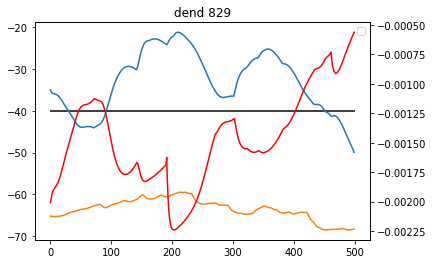

In [61]:
p = 829#np.random.choice(segs[segs.Type=='dend'].index)
plt.title('dend {}'.format(p))
plt.plot(control_v[7200:7700,p],label='dend')
plt.plot(control_v[7200:7700,0],label='soma')
plt.hlines(-40,0,500)
plt.twinx()
plt.plot(control_inmda[7200:7700,p],color='r')
plt.legend()

In [30]:
control_v[10000,0]

-64.93669985517535

(array([574., 247., 275., 347., 151., 246., 123., 100., 155., 308.]),
 array([-68.29374117, -61.6818314 , -55.06992164, -48.45801187,
        -41.8461021 , -35.23419233, -28.62228256, -22.01037279,
        -15.39846303,  -8.78655326,  -2.17464349]),
 <a list of 10 Patch objects>)

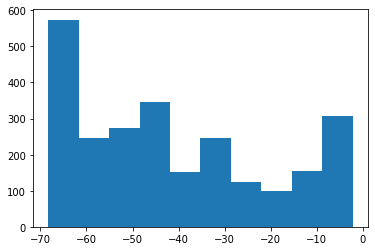

In [29]:
plt.hist(control_v[10000,:])

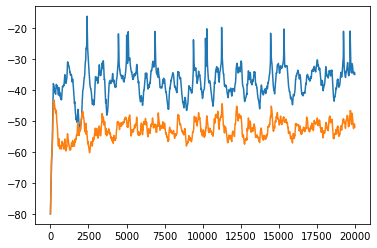

In [27]:
plt.plot(control_v[:,1200])
plt.plot(NMDAblock_v[:,1200])

In [16]:
df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [17]:
df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

(nan, -65.0773572393917)

In [18]:
df[(df.Distance>900) & (df.Distance<1000)]

,BMTK ID,X,Type,Sec ID,Distance,Coord X,Coord Y,Coord Z


(1740, 1760)

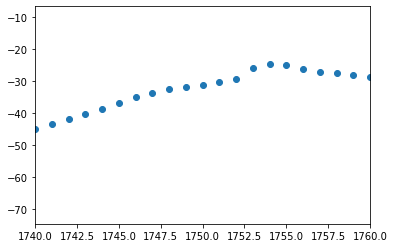

In [19]:
plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
plt.xlim(1740,1760)

Text(0, 0.5, 'mean potential of segment (mV)')

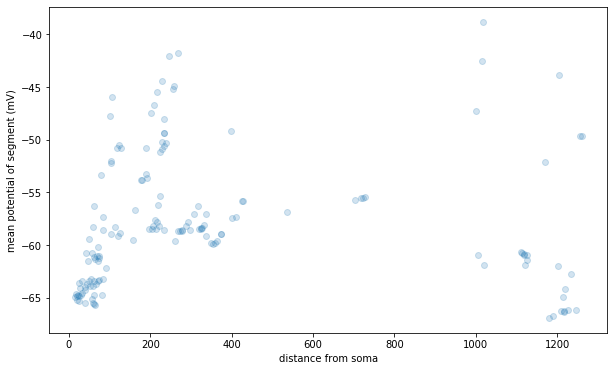

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
plt.xlabel('distance from soma')
plt.ylabel('mean potential of segment (mV)')

Text(0, 0.5, 'membrane potential (mV)')

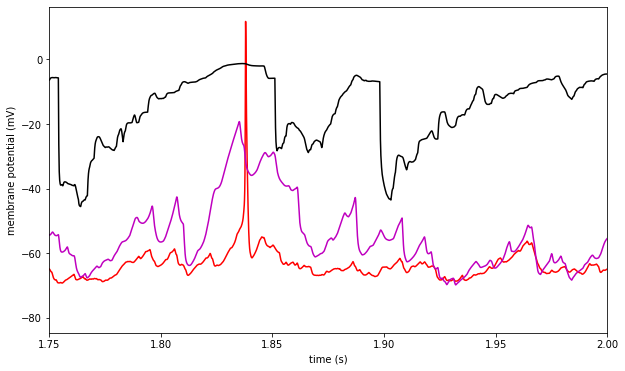

In [22]:
#plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

plt.figure(figsize=(10,6))

plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
plt.xlim(1.75,2)
plt.xlabel('time (s)')
plt.ylabel('membrane potential (mV)')